In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [2]:
df_airline=pd.read_csv('airline_passengers.csv')
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [4]:
df_airline.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [5]:
# Drop the NaN

df_airline.dropna(axis=0,inplace=True)

In [6]:
# Check for NaN Values

df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [7]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [8]:
# Let's convert to date time

df_airline['Month']=pd.to_datetime(df_airline['Month'])

In [9]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [10]:
df_airline.head()

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


**From the above we can see that we have column index starting from `0`. We need to convert the `Month` column to index. Converting the date column to an index creates a DateTimeIndex, which allows pandas to treat the data as a time series. This enables efficient time-based operations like slicing by date, aggregating data over time periods, and using time series-specific plotting tools.**

In [12]:
# Ler's convert date to index

df_airline.set_index('Month',inplace=True)

In [13]:
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


### Let's check the correlation in our data.

In [23]:
y = df_airline['Thousands of Passengers']
y.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: Thousands of Passengers, dtype: float64

In [29]:
y.corr(y)

1.0

In [30]:
y.corr(y.shift(1))

0.9601946480498523

In [31]:
y.corr(y.shift(2))

0.8956753113926396

In [32]:
y.corr(y.shift(3))

0.837394765081794

### We can see that as we go further down the predictive power decreases but we don't want to manually determine the number of lags that will give us the best predictive power so we will use the ACF and the PACF plot.

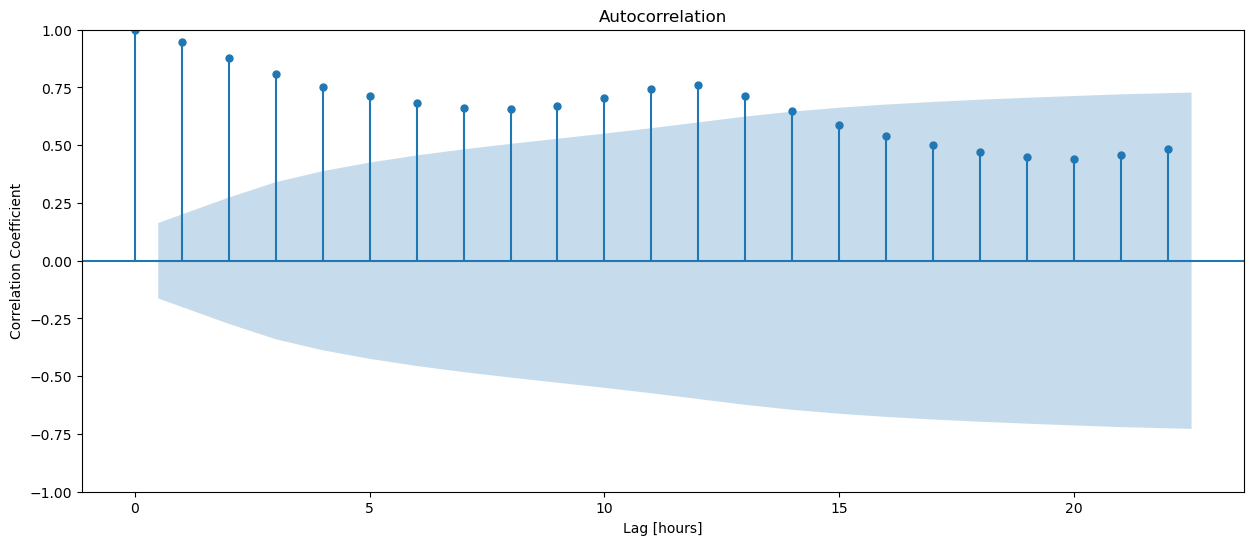

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

### The real to determine how many lags are needed comes from the PACF.

PACF removes the ecoes that are common as you progress along the dataset.

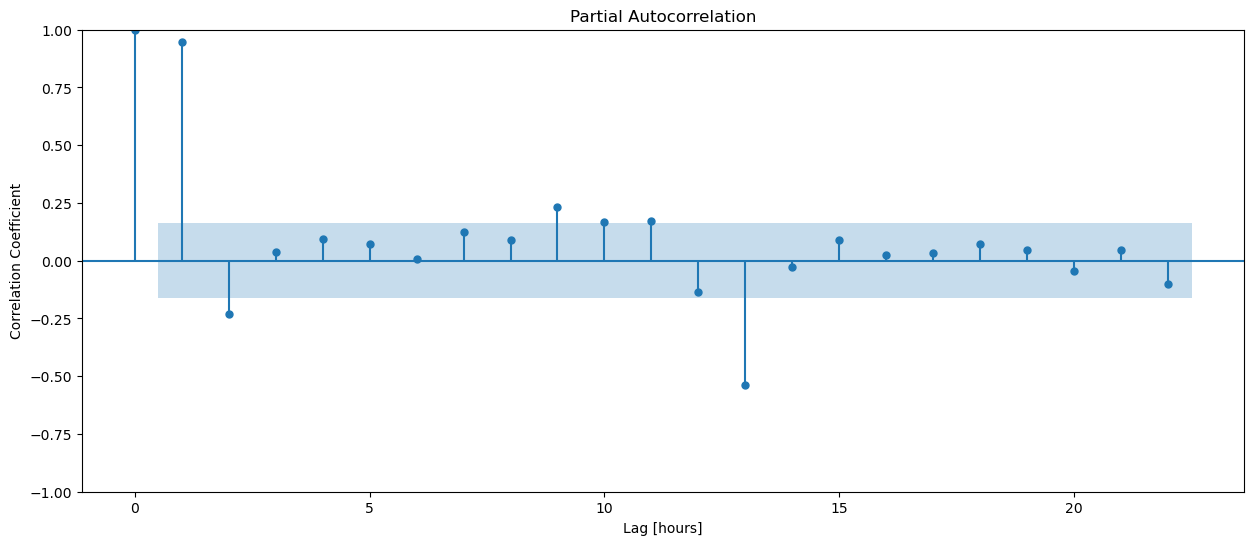

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Split

In [26]:
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

# Build Model

 Baseline

In [35]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean No. Passengers:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean No. Passengers: 267.18
Baseline MAE: 91.52


In [36]:
model = AutoReg(y_train,lags=13).fit()


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Test

In [38]:
model.predict()

1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
                 ...    
1959-12-01    393.853514
1960-01-01    414.320435
1960-02-01    393.776823
1960-03-01    444.303666
1960-04-01    421.534937
Freq: MS, Length: 136, dtype: float64

In [40]:
model.predict().isnull().sum()

13

### The first 13 values are NaN because we are using  a lag of 13.

**Let's us now generate a list of training predictions for our model and use them to calculate our training mean absolute error.**

Note: We'll have to drop the NaN values for the tets to work

In [41]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[13:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 7.970099318015119


### Let's use y_train and y_pred to calculate the residuals for our model.

**Residuals:**

When performing regression analysis, we typically derive a line of best fit. Since real-world data is often messy, the data points usually don’t fall perfectly on this line. Instead, they are scattered around it. A residual is the vertical distance between each individual data point and the regression line. Each data point has a single residual: positive if it’s above the regression line, negative if it’s below, or zero if the line passes directly through the point. Think of it this way: the model represents a theoretical line that exists within the framework of the model. The residuals, on the other hand, are actual values derived from real-world observations.

In [42]:
# Get residuals

y_train_resid = y_train - y_pred
y_train_resid.tail()

1959-12-01    11.146486
1960-01-01     2.679565
1960-02-01    -2.776823
1960-03-01   -25.303666
1960-04-01    39.465063
dtype: float64

### Let's create a Time Series plot of our residuals

<Axes: ylabel='Residual Value'>

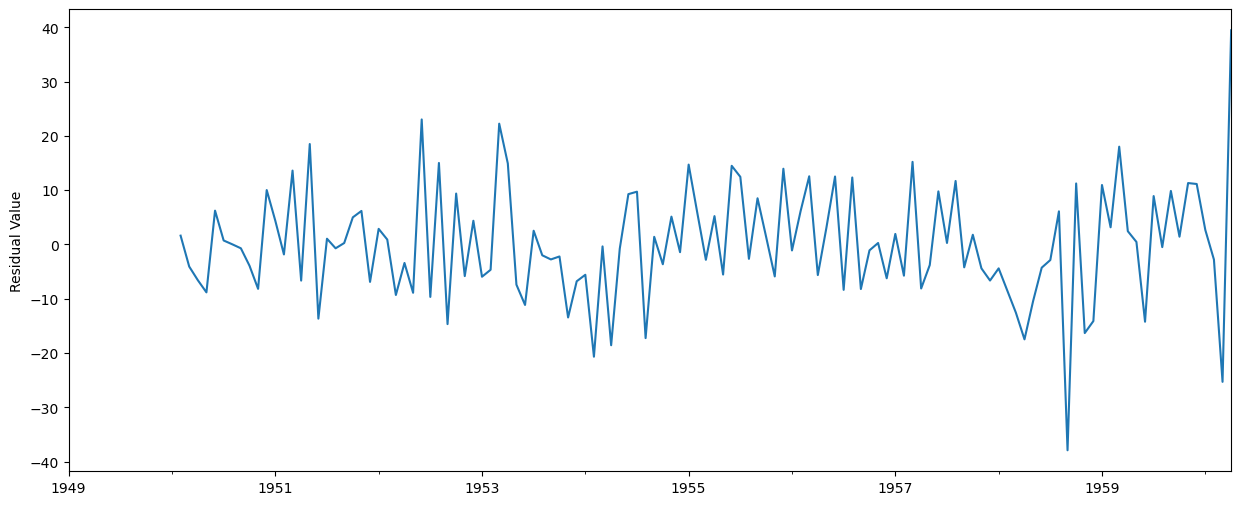

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value",ax=ax)

### A residual that is centered around `0` indicates that our data is normaly distributed and our model is not missing any trend in the data.

### let's create a histogram to further investigate.

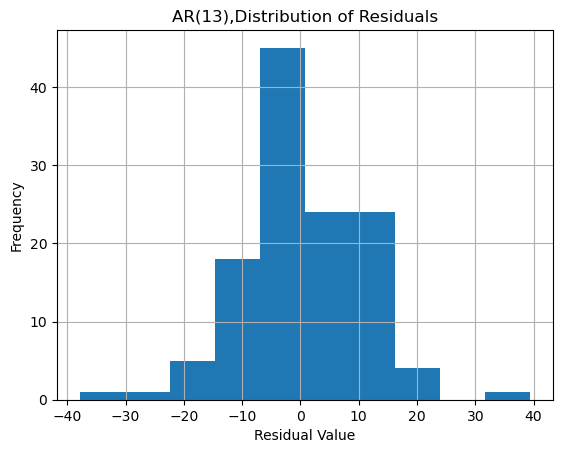

In [45]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(13),Distribution of Residuals");

### We can say that our data is normally distributed.

### Let's create an ACF plot with our residuals.

We expect to get a plot that shows no trend at all which means that the all the significant trends were captured by the ACF and PACF plots and our choice of lag value is correct.

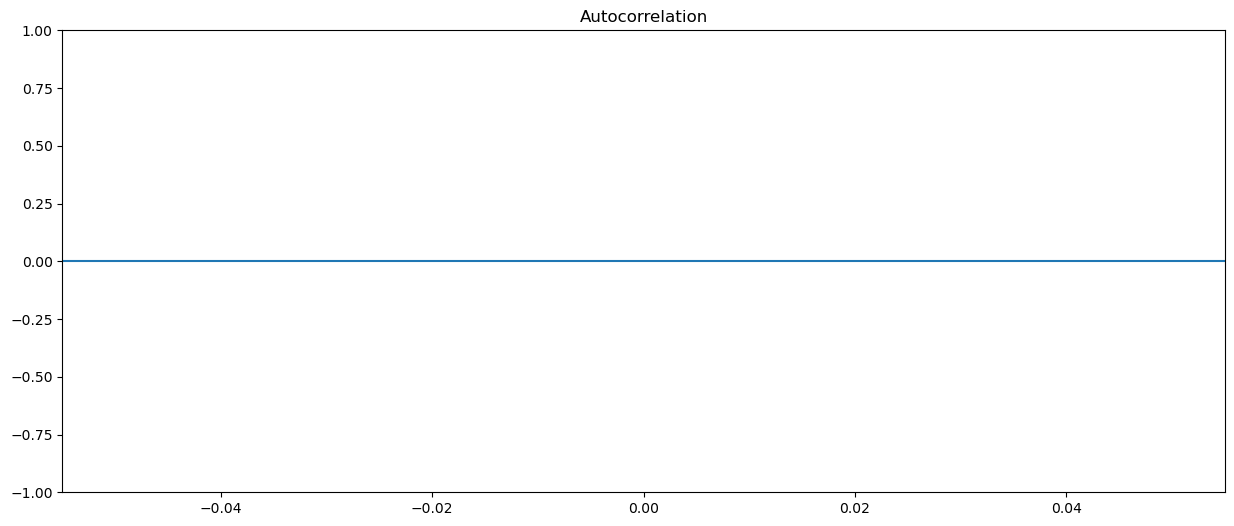

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

### Model Evaluation

In [49]:
y_pred_test = model.predict()
y_pred_test

1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
                 ...    
1959-12-01    393.853514
1960-01-01    414.320435
1960-02-01    393.776823
1960-03-01    444.303666
1960-04-01    421.534937
Freq: MS, Length: 136, dtype: float64

### Let's use time stamps that corresponds with the first and last observations in our `test set`

In [50]:
y_test.head()

Month
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
Name: Thousands of Passengers, dtype: float64

### Here we have `1960-05-01    472.0`

In [52]:
# To get the minimum Time stamp

y_test.index.min()

Timestamp('1960-05-01 00:00:00')

In [51]:
y_test.tail()

Month
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Thousands of Passengers, dtype: float64

### Here we have `1960-12-01    432.0`

In [53]:
# To get the maximum Time stamp

y_test.index.max()

Timestamp('1960-12-01 00:00:00')

In [54]:
# Let's predict

y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 12.482739250729203


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


**Walk Forward Validation**

When performing regression analysis, we typically derive a line of best fit. Since real-world data is often messy, the data points usually don’t fall perfectly on this line. Instead, they are scattered around it. A residual is the vertical distance between each individual data point and the regression line. Each data point has a single residual: positive if it’s above the regression line, negative if it’s below, or zero if the line passes directly through the point. Think of it this way: the model represents a theoretical line that exists within the framework of the model. The residuals, on the other hand, are actual values derived from real-world observations.

In [63]:
history = y_train.copy()
history.tail(1)

Month
1960-04-01    461.0
Name: Thousands of Passengers, dtype: float64

In [61]:
y_test.head(1)

Month
1960-05-01    472.0
Name: Thousands of Passengers, dtype: float64

In [64]:
# Let's use the AR model forecast method to see if we can get the next date

model = AutoReg(history,lags=13).fit()

/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [65]:
model.forecast()

/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



1960-05-01    493.137658
Freq: MS, dtype: float64

In [68]:
%%capture

y_pred_wfv = pd.Series(dtype=float)  # Initialize an empty Series with a defined data type
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])  # Use pd.concat instead of append
    history = pd.concat([history, y_test[next_pred.index]])  # Update history


In [69]:
len(y_pred_wfv)

8

In [70]:
len(y_test)

8

### They both have the same length.

### Let's calculate the test mean absolute error for your model.

In [71]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 13.06


### Comparing `Test MAE (walk forward validation): 13.06` with out Training MAe we can see that they are much closer.

### Communicating the Results

In machine learning, a model's **parameters** are the internal values that are **learned** directly from the training data during the model training process. These parameters define how the model makes predictions based on input data. For example, in linear regression, the slope and intercept of the line are parameters learned to best fit the training data.

In addition to parameters, machine learning involves **hyperparameters**, which are values set manually before the training process begins. These govern the overall behavior and performance of the model, such as the learning rate, the number of layers in a neural network, or the number of neighbors in a k-NN algorithm. Unlike parameters, hyperparameters are not learned from the data but are often tuned through methods like cross-validation to optimize the model's performance.

We’ll delve deeper into hyperparameters and their role in the next module. Understanding the distinction between parameters and hyperparameters is essential for effectively training, tuning, and evaluating machine learning models.

In [72]:
print(model.params)

const                          5.013261
Thousands of Passengers.L1     0.487195
Thousands of Passengers.L2     0.255995
Thousands of Passengers.L3     0.083060
Thousands of Passengers.L4    -0.155062
Thousands of Passengers.L5     0.289629
Thousands of Passengers.L6    -0.025769
Thousands of Passengers.L7    -0.088836
Thousands of Passengers.L8    -0.085794
Thousands of Passengers.L9     0.389014
Thousands of Passengers.L10   -0.419127
Thousands of Passengers.L11   -0.016422
Thousands of Passengers.L12    0.720964
Thousands of Passengers.L13   -0.145757
Thousands of Passengers.L14   -0.415145
Thousands of Passengers.L15    0.121809
Thousands of Passengers.L16   -0.006962
Thousands of Passengers.L17   -0.109823
Thousands of Passengers.L18   -0.228533
Thousands of Passengers.L19    0.304460
Thousands of Passengers.L20   -0.145279
Thousands of Passengers.L21   -0.162424
Thousands of Passengers.L22    0.210217
Thousands of Passengers.L23    0.311815
Thousands of Passengers.L24    0.107461


The output of `model.params` provides the coefficients (parameters) of the **AutoRegressive (AR)** model. These parameters describe the relationship between the current value of the dependent variable (**Thousands of Passengers**) and its past values (lags). Here's a detailed breakdown:

### 1. **Constant Term (`const`)**
   - **Value**: `5.013261`
   - This is the intercept of the model, which represents the baseline value of the dependent variable when all lagged values are zero. It provides a foundation for the prediction.

### 2. **Lag Coefficients**
   - These are the coefficients associated with each lag of the dependent variable, labeled as `Thousands of Passengers.L1`, `Thousands of Passengers.L2`, ..., `Thousands of Passengers.L26`.
   - For example:
     - **`Thousands of Passengers.L1`**: `0.487195` indicates that the value of the dependent variable at lag 1 (one time step before) has a positive effect on the current value, contributing approximately 48.72% of its value to the prediction.
     - **`Thousands of Passengers.L2`**: `0.255995` indicates that the value at lag 2 contributes about 25.60% to the prediction.
     - **`Thousands of Passengers.L10`**: `-0.419127` indicates that the value at lag 10 has a negative influence, reducing the prediction by about 41.91% of its value.

### 3. **Interpretation of Coefficients**
   - A **positive coefficient** means the corresponding lag has a direct (positive) relationship with the current value. When the lag value increases, the predicted value increases proportionally.
   - A **negative coefficient** means the lag has an inverse (negative) relationship. When the lag value increases, the predicted value decreases proportionally.
   - **Magnitude**: Larger absolute values of coefficients indicate a stronger influence of that lag on the prediction. For instance:
     - `Thousands of Passengers.L12` (`0.720964`) has a relatively strong positive effect.
     - `Thousands of Passengers.L10` (`-0.419127`) has a relatively strong negative effect.

### 4. **How This Fits into AR Models**
   - The AutoRegressive (AR) model predicts the current value of the dependent variable based on its previous values (lags). 
   - In this case, the AR model uses 26 lags (`lags=26` was specified), meaning it looks back at the past 26 time steps to make predictions.
   - The model parameters shown here define how each of these past values influences the prediction. 

### 5. **Using the Coefficients**
   - The prediction for the current time step is computed as:  
     \[
     \text{Prediction} = \text{const} + \sum_{i=1}^{26} (\text{Lag Coefficient}_i \times \text{Lag Value}_i)
     \]
   - For example, if the most recent 26 lagged values are known, you can plug them into this equation to calculate the next predicted value.

### 6. **Insights**
   - Some lags have stronger effects (e.g., `L12`) compared to others (e.g., `L16`).
   - Some lags have a negative impact (e.g., `L10`), while others positively influence predictions. 
   - This distribution of coefficients can help you understand how the time series evolves and which past values are more influential in determining future outcomes.

### Let's put the values for y_test and y_pred_wfv into the DataFrame df_pred_test. Then plot df_pred_test using plotly express.



In [75]:
df_pred_test = pd.DataFrame({"y_test":y_test,"y_pred_wfv":y_pred_wfv})
fig = px.line(df_pred_test, labels = {"value":"Thousands of Passengers"})
fig.show()

### We can see that the difference between the outputs of `y_test and y_pred_wfv` are not much. Well done